# Imports

In [0]:
from PIL import Image, ImageDraw
import numpy as np
from sklearn import datasets

# Setup

In [3]:
# Mount CU Drive
from google.colab import drive
drive.mount('/content/drive')

!mkdir drive/My\ Drive/synthetic-ds
!mkdir drive/My\ Drive/synthetic-ds/ct2
!mkdir drive/My\ Drive/synthetic-ds/ctp2
!mkdir drive/My\ Drive/synthetic-ds/squares
!mkdir drive/My\ Drive/synthetic-ds/point
!mkdir drive/My\ Drive/synthetic-ds/point/circles
!mkdir drive/My\ Drive/synthetic-ds/point/s_curves
!mkdir drive/My\ Drive/synthetic-ds/point/swiss_roll

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/ct2’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/ctp2’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/squares’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/point’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/point/circl

# Image Dataset Generation

## Squares

### Generation

In [0]:
def get_sample(mean, stdev):
    return np.random.multivariate_normal(mean, (stdev**2)*np.identity(2))

def gen_mixture(no_of_dist, dataset_size, scaling_factor = (100, 10)):
    # Generate means and stdev of the mixture
    mean = np.random.rand(no_of_dist, 2)* scaling_factor[0]
    stdev = np.random.rand(no_of_dist)* scaling_factor[1]

    # Generate dataset
    idx = np.random.randint(0, high = no_of_dist, size = dataset_size)
    mean_arr = mean[idx]
    stdev_arr = stdev[idx]

    data = np.zeros((dataset_size, 2))
    for i in range(dataset_size):
        data[i] = get_sample(mean_arr[i], stdev_arr[i])
    
    return idx, data, mean, stdev

# Fixed size of images : 64 x 64 x 1
# For simplicity keep size of squares to be exponents of 2 i.e. 2, 4, 8 ...
def draw_square(im, square_size, im_size, top_left = None):
    if top_left is None:
      top_left = np.random.randint(0, high = im_size - square_size, size = 2)
    
    # Set colour 
    im[top_left[0] : top_left[0] + square_size, top_left[1] : top_left[1] + square_size] = 1

    return im, top_left

def non_overlapping_square(im, no_of_squares, square_size, im_size):
    bad_corners = True
    while bad_corners:
        top_left = np.random.randint(0, high = im_size - square_size - 1, size = (no_of_squares, 2))
        new_im = np.copy(im)
        found_combination = False
        for i in range(0, no_of_squares):
            relevant_square = new_im[top_left[i][0]: top_left[i][0] + square_size, top_left[i][1] : top_left[i][1] + square_size] 
            neighbors = relevant_square[relevant_square == 1]
            if neighbors.shape[0] == 0:
                draw_square(new_im, square_size, im_size, top_left[i])
                if i == no_of_squares - 1:
                    found_combination = True
            else:
                bad_corners = True
                break

        if bad_corners and not found_combination:
            continue
        bad_corners = False
    return new_im



def gen_square_image(no_of_squares, square_size, overlap, im_size):
    im = np.zeros((im_size, im_size))

    idx = []
    if overlap:
        for i in range(no_of_squares):
            im, ind = draw_square(im, square_size, im_size)
            idx.append(ind)
    else:
        im = non_overlapping_square(im, no_of_squares, square_size, im_size)

    return im
  
def gen_square_dataset(no_of_squares, square_size, dataset_size, overlap, im_size = 128):
  ds = np.zeros((dataset_size, im_size, im_size))
  for i in range(dataset_size):
    ds[i] = gen_square_image(no_of_squares, square_size, overlap, im_size)
  return ds

In [0]:
# Save dataset with 1 square of size 32 
ds = gen_square_dataset(1, 32, 5000, False)
np.save("drive/My Drive/synthetic-ds/squares/1-32.npy", ds)

# Save dataset with 4 squares of size 16 
ds = gen_square_dataset(4, 16, 5000, False)
np.save("drive/My Drive/synthetic-ds/squares/4-16.npy", ds)

# Save dataset with 10 squares of size 8 
ds = gen_square_dataset(10, 8, 5000, False)
np.save("drive/My Drive/synthetic-ds/squares/10-8.npy", ds)

# Save dataset with 1 square of size 16 in 28x28
ds = gen_square_dataset(1, 16, 5000, False, im_size = 28)
np.save("drive/My Drive/synthetic-ds/squares/1-16-28x28.npy", ds)

# Save dataset with 3 squares of size 4 
ds = gen_square_dataset(3, 4, 5000, False, im_size = 28)
np.save("drive/My Drive/synthetic-ds/squares/3-4-28x28.npy", ds)

### Load

In [0]:
squares_1_32 = np.load("drive/My Drive/synthetic-ds/squares/1-32.npy")
squares_4_16 = np.load("drive/My Drive/synthetic-ds/squares/4-16.npy")
squares_10_8 = np.load("drive/My Drive/synthetic-ds/squares/10-8.npy")
squares_1_16_28 = np.load("drive/My Drive/synthetic-ds/squares/1-16-28x28.npy")
squares_3_4_28 = np.load("drive/My Drive/synthetic-ds/squares/3-4-28x28.npy")

## Mixture of Polygons

### Code

In [0]:
def generate_ct2(im_path, im_size):
  image = Image.new('RGB', (im_size, im_size))
  image.save(im_path, "PNG")
  
  image = Image.open(im_path)
  draw = ImageDraw.Draw(image)

  # Draw 2 circles
  x = np.random.randint(10, high = im_size - 10)
  y = np.random.randint(10, high = im_size - 10)
  r = np.random.randint(min(x, y, im_size - x, im_size - y))
  draw.ellipse((x-r, y-r, x+r, y+r), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  x = np.random.randint(10, high = im_size - 10)
  y = np.random.randint(10, high = im_size - 10)
  r = np.random.randint(min(x, y, im_size - x, im_size - y))
  draw.ellipse((x-r, y-r, x+r, y+r), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  # Draw 2 triangles
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))

  image.save(im_path)
  
def generate_ctp2(im_path, im_size):
  # Create new image (all black)
  image = Image.new('RGB', (im_size, im_size))
  draw = ImageDraw.Draw(image)

  # Draw 2 circles
  x = np.random.randint(10, high = im_size - 10)
  y = np.random.randint(10, high = im_size - 10)
  r = np.random.randint(min(x, y, im_size - x, im_size - y))
  draw.ellipse((x-r, y-r, x+r, y+r), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  x = np.random.randint(10, high = im_size - 10)
  y = np.random.randint(10, high = im_size - 10)
  r = np.random.randint(min(x, y, im_size - x, im_size - y))
  draw.ellipse((x-r, y-r, x+r, y+r), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  # Draw 2 triangles
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  # Draw 2 polygons (4 sided)
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))

  image.save()

def gen_image_dataset(image_name, im_size, dataset_size, image_generator, path):
  im_path = path + image_name
  for i in range(dataset_size):
    image_generator(im_path + str(i) + '.png', im_size)

### Generation

In [0]:
gen_image_dataset('image', 128, 5000, generate_ct2, 'drive/My Drive/synthetic-ds/ct2/')
gen_image_dataset('image', 128, 5000, generate_ctp2, 'drive/My Drive/synthetic-ds/ctp2/')

### Utilites for testing

In [0]:
# Check if the files have been generated 
!ls drive/My\ Drive/synthetic-ds/ct2/
!ls drive/My\ Drive/synthetic-ds/ctp2/

In [0]:
# Delete all files in relevant folders
!rm drive/My\ Drive/synthetic-ds/ct2/*
!rm drive/My\ Drive/synthetic-ds/ctp2/*

rm: cannot remove 'drive/My Drive/synthetic-ds/ctp2/*': No such file or directory


# Point (in $R^n$) Dataset Generation 

## Circles

### Generation

In [0]:
circle_factor_1 = datasets.make_circles(n_samples = 5000, factor = 0.1, random_state = 0)
circle_factor_5 = datasets.make_circles(n_samples = 5000, factor = 0.5, random_state = 0)
circle_factor_9 = datasets.make_circles(n_samples = 5000, factor = 0.9, random_state = 0)

circle_noise_5 = datasets.make_circles(n_samples = 5000, factor = 0.5, noise = 0.05, random_state = 0)
circle_noise_10 = datasets.make_circles(n_samples = 5000, factor = 0.5, noise = 0.1, random_state = 0)
circle_noise_50 = datasets.make_circles(n_samples = 5000, factor = 0.5, noise = 0.5, random_state = 0)

In [0]:
np.save('drive/My Drive/synthetic-ds/point/circles/circle_factor_1', np.column_stack((circle_factor_1[0], circle_factor_1[1])))
np.save('drive/My Drive/synthetic-ds/point/circles/circle_factor_5', np.column_stack((circle_factor_5[0], circle_factor_5[1])))
np.save('drive/My Drive/synthetic-ds/point/circles/circle_factor_9', np.column_stack((circle_factor_9[0], circle_factor_9[1])))

np.save('drive/My Drive/synthetic-ds/point/circles/circle_noise_5', np.column_stack((circle_noise_5[0], circle_noise_5[1])))
np.save('drive/My Drive/synthetic-ds/point/circles/circle_noise_10', np.column_stack((circle_noise_10[0], circle_noise_10[1])))
np.save('drive/My Drive/synthetic-ds/point/circles/circle_noise_50', np.column_stack((circle_noise_50[0], circle_noise_50[1])))

### Load

In [0]:
circle_factor_1 = np.load('drive/My Drive/synthetic-ds/point/circles/circle_factor_1.npy')
circle_factor_5 = np.load('drive/My Drive/synthetic-ds/point/circles/circle_factor_5.npy')
circle_factor_9 = np.load('drive/My Drive/synthetic-ds/point/circles/circle_factor_9.npy')

circle_noise_5 = np.load('drive/My Drive/synthetic-ds/point/circles/circle_noise_5.npy')
circle_noise_10 = np.load('drive/My Drive/synthetic-ds/point/circles/circle_noise_10.npy')
circle_noise_50 = np.load('drive/My Drive/synthetic-ds/point/circles/circle_noise_50.npy')

## S Curve

### Generation

In [0]:
scurve_noise_5 = datasets.make_s_curve(n_samples = 5000, noise = 0.05, random_state = 0)
scurve_noise_10 = datasets.make_s_curve(n_samples = 5000, noise = 0.1, random_state = 0)
scurve_noise_50 = datasets.make_s_curve(n_samples = 5000, noise = 0.5, random_state = 0)

In [0]:
np.save('drive/My Drive/synthetic-ds/point/s_curves/scurve_noise_5', np.column_stack((scurve_noise_5[0], scurve_noise_5[1])))
np.save('drive/My Drive/synthetic-ds/point/s_curves/scurve_noise_10', np.column_stack((scurve_noise_10[0], scurve_noise_10[1])))
np.save('drive/My Drive/synthetic-ds/point/s_curves/scurve_noise_50', np.column_stack((scurve_noise_50[0], scurve_noise_50[1])))

### Load

In [0]:
scurve_noise_5 = np.load('drive/My Drive/synthetic-ds/point/s_curves/scurve_noise_5.npy')
scurve_noise_10 = np.load('drive/My Drive/synthetic-ds/point/s_curves/scurve_noise_10.npy')
scurve_noise_50 = np.load('drive/My Drive/synthetic-ds/point/s_curves/scurve_noise_50.npy')

## Swiss Roll

### Generation

In [0]:
roll_noise_5 = datasets.make_swiss_roll(n_samples = 5000, noise = 0.05, random_state = 0)
roll_noise_10 = datasets.make_swiss_roll(n_samples = 5000, noise = 0.1, random_state = 0)
roll_noise_50 = datasets.make_swiss_roll(n_samples = 5000, noise = 0.5, random_state = 0)

In [0]:
np.save('drive/My Drive/synthetic-ds/point/swiss_roll/roll_noise_5', np.column_stack((roll_noise_5[0], roll_noise_5[1])))
np.save('drive/My Drive/synthetic-ds/point/swiss_roll/roll_noise_10', np.column_stack((roll_noise_10[0], roll_noise_10[1])))
np.save('drive/My Drive/synthetic-ds/point/swiss_roll/roll_noise_50', np.column_stack((roll_noise_50[0], roll_noise_50[1])))

### Load

In [0]:
roll_noise_5 = np.load('drive/My Drive/synthetic-ds/point/swiss_roll/roll_noise_5.npy')
roll_noise_10 = np.load('drive/My Drive/synthetic-ds/point/swiss_roll/roll_noise_10.npy')
roll_noise_50 = np.load('drive/My Drive/synthetic-ds/point/swiss_roll/roll_noise_50.npy')

## Clusters

In [16]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, input_dim=self.latent_dim))
        #model.add(Activation("relu"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Activation("relu"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Activation("relu"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        '''
        
        X_train = np.load('drive/My Drive/synthetic-ds/squares/3-4-28x28.npy')
        X_train = X_train/0.5 - 1
        X_train = np.expand_dims(X_train, axis=3)
        '''
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            
            if epoch%1000 == 0:
              # Plot the progress
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=300000, batch_size=32, save_interval=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.084551, acc.: 39.06%] [G loss: 0.905746]
1000 [D loss: 0.641972, acc.: 57.81%] [G loss: 1.065750]
2000 [D loss: 0.668911, acc.: 62.50%] [G loss: 0.991264]
3000 [D loss: 0.594928, acc.: 68.75%] [G loss: 1.076152]
4000 [D loss: 0.670564, acc.: 54.69%] [G loss: 0.845422]
5000 [D loss: 0.573365, acc.: 73.44%] [G loss: 1.218298]
6000 [D loss: 0.634142, acc.: 64.06%] [G loss: 1.095948]
7000 [D loss: 0.754970, acc.: 48.44%] [G loss: 1.051003]
8000 [D loss: 0.711480, acc.: 54.69%] [G loss: 1.029478]
9000 [D loss: 0.640849, acc.: 62.50%] [G loss: 1.702682]
10000 [D loss: 0.509681, acc.: 73.44%] [G loss: 1.491481]
11000 [D loss: 0.550764, acc.: 75.00%] [G loss: 1.512146]
12000 [D loss: 0.575247, acc.: 68.75%] [G loss: 1.629281]
13000 [D loss: 0.440719, acc.: 79.69%] [G loss: 1.456064]
14000 [D loss: 0.651906, acc.: 60.94%] [G loss: 1.299633]
15000 [D loss: 0.567971, acc.: 67.19%] [G loss: 1.558935]
16000 [D loss: 0.363465, acc.: 87.50%] [G loss: 2.205431]
17000 [D loss: 0.324507, ac

In [8]:
!mkdir images
!rm images/*

rm: cannot remove 'images/*': No such file or directory


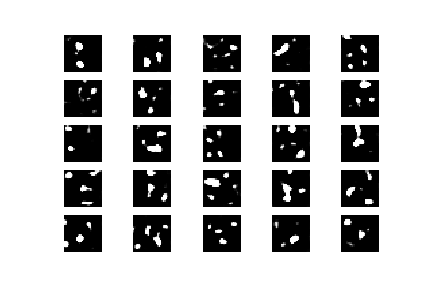

In [23]:
from IPython.display import Image
Image(filename='images/mnist_1000.png')

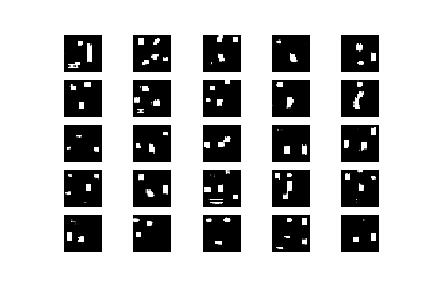

In [24]:
from IPython.display import Image
Image(filename='images/mnist_9000.png')

In [0]:
!mkdir images/

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import sys

from PIL import Image

import numpy as np

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class WGANGP():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        # Generate image based of noise (fake sample)
        fake_img = self.generator(z_disc)

        # Discriminator determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(100,))
        # Generate images based of noise
        img = self.generator(z_gen)
        # Discriminator determines validity
        valid = self.critic(img)
        # Defines generator model
        self.generator_model = Model(z_gen, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)


    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size, sample_interval=50):
        '''
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        '''
        X_train = np.load('drive/My Drive/synthetic-ds/squares/3-4-28x28.npy')
        X_train = X_train/0.5 - 1
        X_train = np.expand_dims(X_train, axis=3)
        print(X_train.shape)
        
        #X_train += np.reshape(np.random.normal(0, 0.1, X_train.shape[0]*X_train.shape[1]*X_train.shape[2]*X_train.shape[3]), X_train.shape)
        
        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake =  np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, noise],
                                                                [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.generator_model.train_on_batch(noise, valid)
            
            if epoch%1000 == 0:
              # Plot the progress
              print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
              self.generator.save('gen_model')
              self.critic.save('critic_model')

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.show()
        plt.close()
       


if __name__ == '__main__':
    wgan = WGANGP()
    wgan.train(epochs=10000, batch_size=32, sample_interval=1000)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_s

FileNotFoundError: ignored

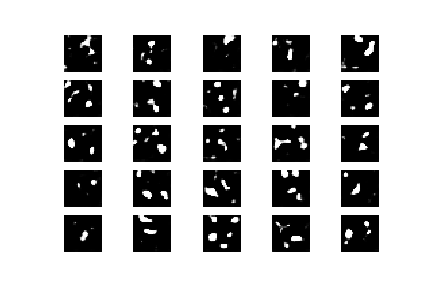

In [31]:
from IPython.display import Image
Image(filename='images/mnist_1000.png')

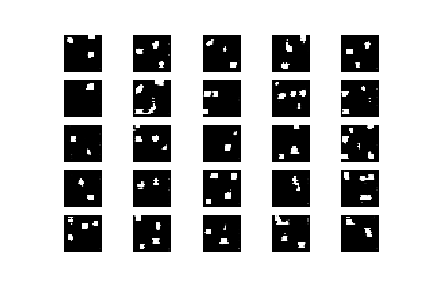

In [32]:
from IPython.display import Image
Image(filename='images/mnist_9000.png')

In [33]:
!ls

ak.jpg				gdrive		     LICENSE
architecture.svg		gen_model	     mkdocs.yml
CaltechAUTHORS:CNS-TR-2007-001	headers.py	     README.rst
critic_model			images		     sample_data
docs				importance_sampling  scripts
drive				importance-sampling  setup.py
examples			__init__.py	     tests


# Point DS

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 8)                 24        
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 8)                 0         
_________________________________________________________________
dense_42 (Dense)             (None, 16)                144       
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 8)                 136       
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 8)                 0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 9         
Total para

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.696995, acc.: 29.69%] [G loss: 0.679093]


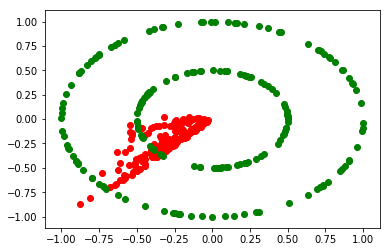

5000 [D loss: 0.692343, acc.: 53.12%] [G loss: 0.695463]


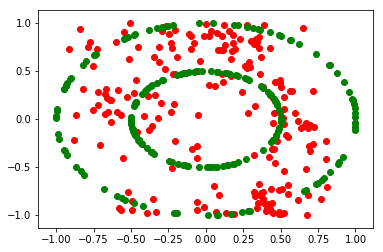

10000 [D loss: 0.692756, acc.: 50.00%] [G loss: 0.719191]


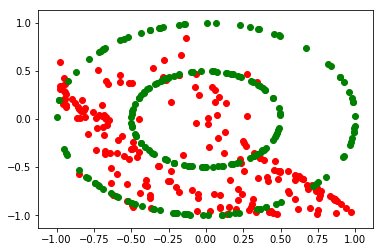

15000 [D loss: 0.659185, acc.: 71.88%] [G loss: 0.708906]


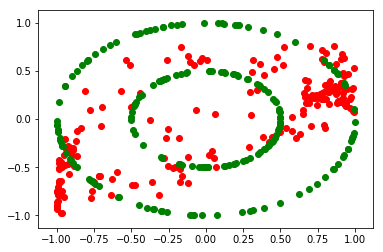

20000 [D loss: 0.651310, acc.: 71.88%] [G loss: 0.787419]


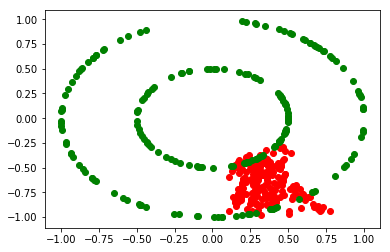

25000 [D loss: 0.694942, acc.: 51.56%] [G loss: 0.739908]


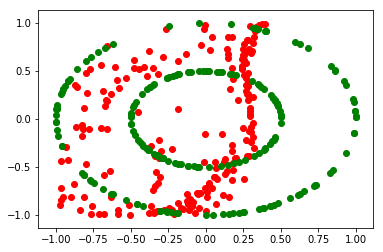

30000 [D loss: 0.691755, acc.: 59.38%] [G loss: 0.700024]


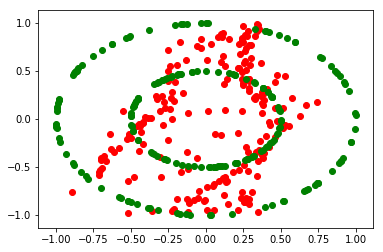

35000 [D loss: 0.689898, acc.: 59.38%] [G loss: 0.699783]


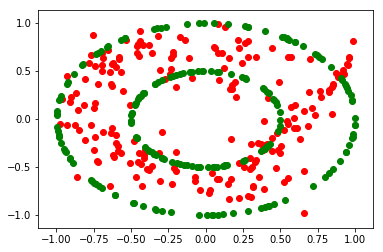

40000 [D loss: 0.689491, acc.: 68.75%] [G loss: 0.693146]


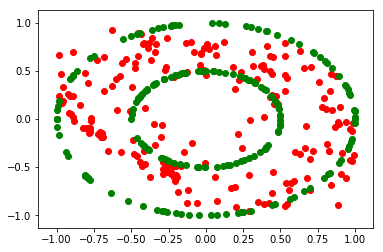

45000 [D loss: 0.691288, acc.: 53.12%] [G loss: 0.699538]


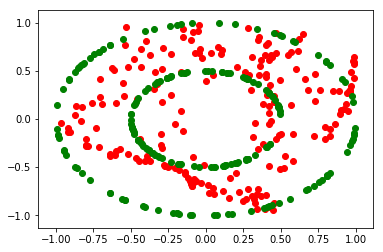

50000 [D loss: 0.694867, acc.: 43.75%] [G loss: 0.694817]


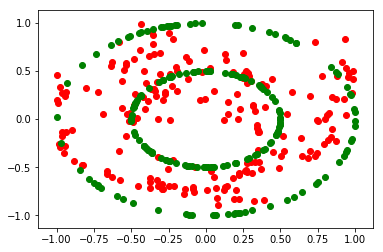

55000 [D loss: 0.695038, acc.: 43.75%] [G loss: 0.688082]


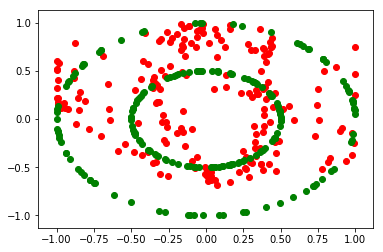

60000 [D loss: 0.690411, acc.: 62.50%] [G loss: 0.690721]


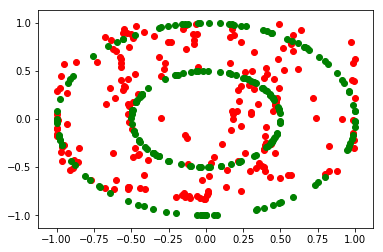

65000 [D loss: 0.691939, acc.: 59.38%] [G loss: 0.691062]


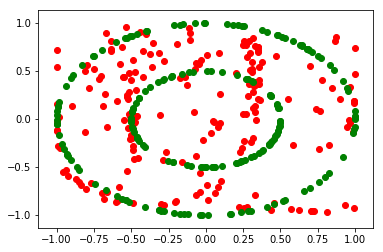

70000 [D loss: 0.692349, acc.: 59.38%] [G loss: 0.689756]


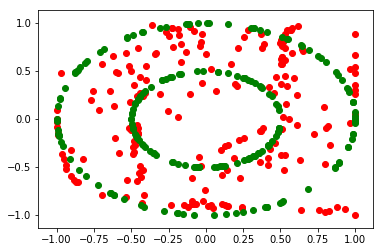

75000 [D loss: 0.695739, acc.: 53.12%] [G loss: 0.697083]


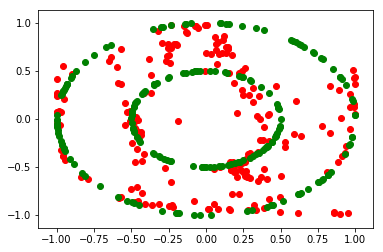

80000 [D loss: 0.692466, acc.: 50.00%] [G loss: 0.680005]


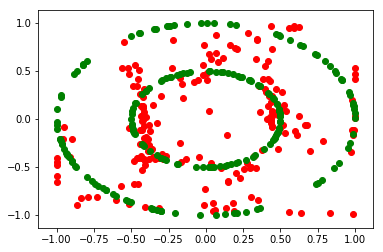

85000 [D loss: 0.691044, acc.: 64.06%] [G loss: 0.687114]


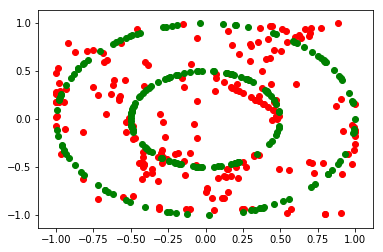

90000 [D loss: 0.688303, acc.: 59.38%] [G loss: 0.692048]


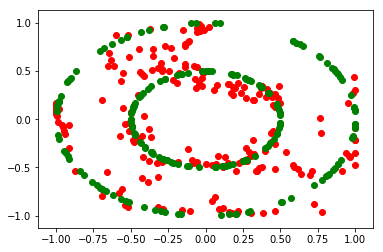

95000 [D loss: 0.687905, acc.: 64.06%] [G loss: 0.699203]


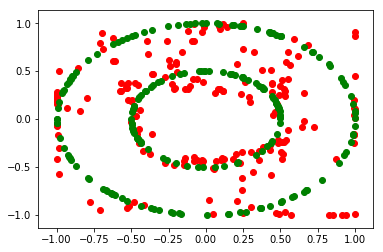

100000 [D loss: 0.688031, acc.: 57.81%] [G loss: 0.691320]


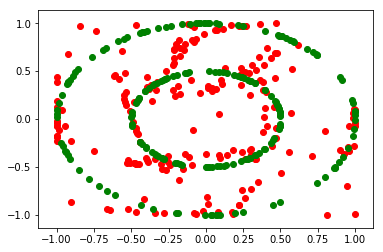

105000 [D loss: 0.690781, acc.: 48.44%] [G loss: 0.694427]


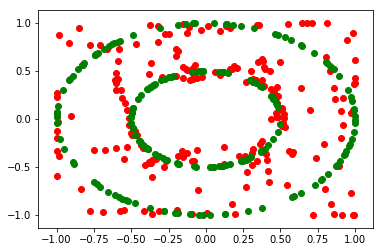

110000 [D loss: 0.693776, acc.: 54.69%] [G loss: 0.698452]


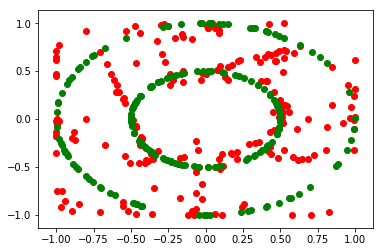

115000 [D loss: 0.684599, acc.: 64.06%] [G loss: 0.690677]


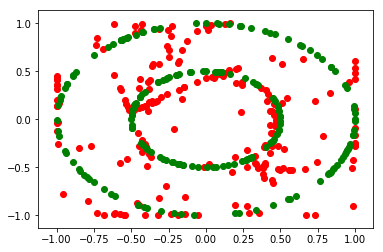

120000 [D loss: 0.689267, acc.: 56.25%] [G loss: 0.694064]


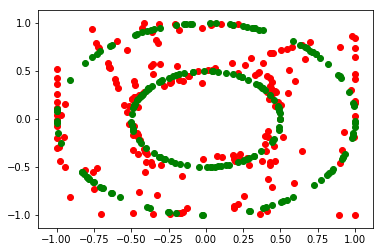

125000 [D loss: 0.690554, acc.: 46.88%] [G loss: 0.706912]


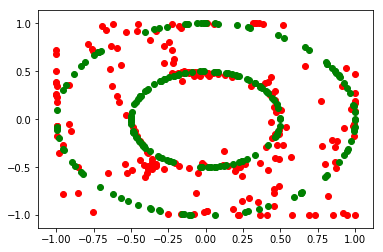

130000 [D loss: 0.684398, acc.: 54.69%] [G loss: 0.696517]


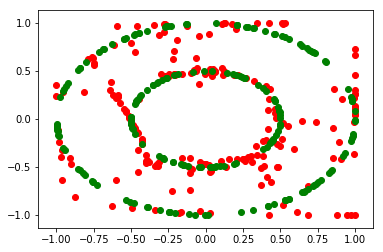

KeyboardInterrupt: ignored

In [28]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        self.out_shape = 2
        self.latent_dim = 2

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(8, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        
        model.add(Dense(16, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        
        model.add(Dense(8, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
    
        model.add(Dense(self.out_shape, activation='tanh'))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(8, input_dim=self.out_shape))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(16, input_dim=self.out_shape))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(8, input_dim=self.out_shape))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=(self.out_shape,))
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        '''
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        '''
        #X_train, _ = circle_factor_1
        #X_train, _ = datasets.make_blobs(n_samples = 5000,  random_state = 100, centers = 3)
        X_train = circle_factor_5[:,:2]
        scale = max(abs(np.amin(X_train)), np.max(X_train))
        X_train = X_train/(scale)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            if epoch%sample_interval == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                #self.sample_images(epoch)
                noise = np.random.normal(0, 1, (200, self.latent_dim))
                gen_imgs = self.generator.predict(noise)
                
                idx = np.random.randint(0, high = 5000, size = 200)
                x, y = X_train[idx,0], X_train[idx,1]
                plt.scatter(gen_imgs[:,0], gen_imgs[:,1], color = 'red')
                plt.scatter(x, y, color = 'green')
                plt.show()
                
                

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=200000, batch_size=32, sample_interval=5000)

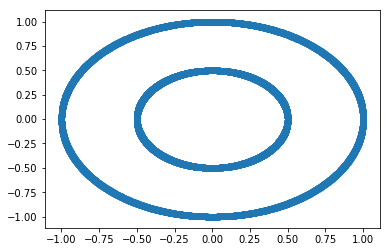

In [104]:
X_train, _ = circle_factor_5
scale = max(abs(np.amin(X_train)), np.max(X_train))
X_train = X_train/(scale)
plt.scatter(X_train[:,0], X_train[:,1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 8)                 24        
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                144       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 136       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 18        
Total para

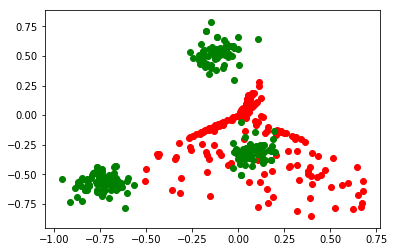

KeyboardInterrupt: ignored

In [24]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class WGANGP():
    def __init__(self):
        self.out_shape = 2
        self.latent_dim = 2

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=(self.out_shape,))

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        # Generate image based of noise (fake sample)
        fake_img = self.generator(z_disc)

        # Discriminator determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        print(real_img.shape)
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(self.latent_dim,))
        # Generate images based of noise
        img = self.generator(z_gen)
        # Discriminator determines validity
        valid = self.critic(img)
        # Defines generator model
        self.generator_model = Model(z_gen, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)


    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(8, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(16, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(8, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
    
        model.add(Dense(self.out_shape, activation='tanh'))
        model.summary()

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Dense(8, input_dim=self.out_shape))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(16, input_dim=self.out_shape))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(8, input_dim=self.out_shape))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=(self.out_shape,))
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size, sample_interval=50):
        '''
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        '''
        X_train, _ = datasets.make_blobs(n_samples = 5000,  random_state = 100, centers = 3)
        scale = max(abs(np.amin(X_train)), np.max(X_train))
        X_train = X_train/(scale)
        
        #X_train += np.reshape(np.random.normal(0, 0.1, X_train.shape[0]*X_train.shape[1]*X_train.shape[2]*X_train.shape[3]), X_train.shape)
        
        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake =  np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, noise],
                                                                [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.generator_model.train_on_batch(noise, valid)
            
            if epoch%2000 == 0:
              # Plot the progress
              print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
              self.generator.save('gen_model')
              self.critic.save('critic_model')

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                #self.sample_images(epoch)
                noise = np.random.normal(0, 1, (200, self.latent_dim))
                gen_imgs = self.generator.predict(noise)
                
                idx = np.random.randint(0, high = 5000, size = 200)
                x, y = X_train[idx,0], X_train[idx,1]
                plt.scatter(gen_imgs[:,0], gen_imgs[:,1], color = 'red')
                plt.scatter(x, y, color = 'green')
                plt.show()

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    wgan = WGANGP()
    wgan.train(epochs=50000, batch_size=32, sample_interval=2000)

In [25]:
K.random_uniform((32, 1))

<tf.Tensor 'random_uniform:0' shape=(32, 1) dtype=float32>